# Table of Contents
1 - [Problem Statement](#ps)  
2 - [Overview of Dataset](#dataset)  
3 - [Loading the Data](#load)    
4 - [Text Preprocessing Using NLTK](#textprep)  
5 - [Train and Test Split of Data](#split)  
6 - [Support Vector Machine Classification](#svm)  
&emsp;  6.1 - [Function to find the test accuracy using SGD hinge loss(10 fold cv)](#hinge)  
&emsp;  6.2 - [Function to find the optimal C and gamma using SVC(10 fold cv)](#kernel)  
&emsp;  6.3 - [Function to predict on Test Data and report Performance](#acc)   
7 - [Featurization Methods](#vec)  
&emsp;  7.1 - [Bag Of Words(unigram)](#bowuni)   
&emsp;  7.2 - [Bag Of Words(bigram)](#bowbi)  
&emsp;  7.3 - [TF-IDF(unigram)](#tfidfuni)  
&emsp;  7.4 - [TF-IDF(bigram)](#tfidfbi)   
&emsp;  7.5 - [Average Word2Vec](#avgw2v)  
&emsp;  7.6 - [TF-IDF Weighted Word2Vec](#tfidfw2v)  
8 - [Conclusion](#conclusion)

## [1] Problem Statement : <a name="ps"></a>

-  Time Based slicing(100k data points) to split Train Data(70%) and Test Data(30%).
-  Appling SVC with rbf kernel model to find the optimal C and gamma using K fold Cross Validation(both grid serach and random serach).    
-  Comparsion of various performance metrics obtained by various featurization models. 

#### [1.1] APPROACH FOLLOWED :
-  Since SVC with kernel rbf has very high time complexity, SGD with hinge loss is applied to all the featurization models and performance is recorded.

-  Then SVC rbf is applied to the model that performs best with SGD hinge loss.
Both Grid and Random Serach is applied to find the best hyperparameters of svc rbf.

## [2] Overview of Dataset : <a name="dataset"></a>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.  

Number of reviews: 568,454  
Number of users: 256,059  
Number of products: 74,258  
Timespan: Oct 1999 - Oct 2012  
Number of Attributes/Columns in data: 10  

Attribute Information:

&emsp;1.Id  
&emsp;2.ProductId - unique identifier for the product  
&emsp;3.UserId - unqiue identifier for the user  
&emsp;4.ProfileName  
&emsp;5.HelpfulnessNumerator - number of users who found the review helpful  
&emsp;6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not  
&emsp;7.Score - rating between 1 and 5  
&emsp;8.Time - timestamp for the review  
&emsp;9.Summary - brief summary of the review  
&emsp;10.Text - text of the review  

Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## [3] Loading the Data : <a name="load"></a>

In order to load the data, we have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
#Importing the necessary Packages
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import time
from tqdm import tqdm
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import HTML
from collections import OrderedDict


from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [3]:
import pickle

#dumping an object to file object using dump method
def dumpfile(a,file_Name):
    fileObject = open(file_Name,"wb")
    pickle.dump(a,fileObject,protocol=2)
    fileObject.close()

#loading an object from file object using load method
def loadfile(file_Name):
    fileObject = open(file_Name,"rb")
    b = pickle.load(fileObject)
    return b

## [4] Text Preprocessing Using NLTK : <a name="textprep"></a>

In the Preprocessing phase we do the following in the order below:-

1. Removal of HTML Tags
2. Removal of  any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Removal of  Stopwords
7. Finally Snowball Stemming the word <br>

After which we collect the words used to describe positive and negative reviews

### [4.1] Using SQLite Table to load preprocessed data already saved in disk:

In [4]:
# using the SQLite Table to read data.
conn = sqlite3.connect('final.sqlite') 

final = pd.read_sql_query(""" SELECT * FROM Reviews """,conn) 

In [5]:
#Listing out the number of positive and negative reviews
final = final.reset_index(drop=True)
final['Score'].value_counts()

positive    306566
negative     57033
Name: Score, dtype: int64

In [6]:
(final['Score'].value_counts()/len(final['Score']))*100

positive    84.314313
negative    15.685687
Name: Score, dtype: float64

## [5] Train and Test Split of Data : <a name="split"></a>

<b>Sorting the data by Time :</b>

In [7]:
final = final.sample(n = 100000)

final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
209,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
179,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
225,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
206,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
260,346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,positive,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,beetlejuic wonder amus comed romp explor incre...


In [8]:
def reviews(x):
    if x == 'positive':
        return 1
    else:
        return 0
    
final['Score'] = final['Score'].map(reviews)

In [9]:
from sklearn.model_selection import train_test_split

X = final["CleanedText"].values
y = final["Score"].values
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False)

In [10]:
print("Shape of X_train: ",X_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of X_train:  (70000,)
Shape of y_train:  (70000,)
Shape of X_test:  (30000,)
Shape of y_test:  (30000,)


## [6] Support Vector Machine Classification : <a name="svm"></a>

### [6.1] Function to find the test accuracy using SGD hinge loss(10 fold cv): <a name="hinge"></a>
-  <b>SGD with hinge loss</b> is equivalent to <b>linear svm</b>
-  Performing 10 fold cross validation(Grid Search) on Train data 
-  Finding the optimal depth
-  Plotting between CV F1-score and alpha
-  Predicting on Test Data and plotting Confusion Matrix
-  Reporting Performance Metrics

In [13]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score as cv
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import roc_curve,auc

alpha_values = [0.0001,0.001, 0.01, 0.1, 1, 10,100]
param_sgd = dict(alpha = alpha_values)

def SGD_Train(x,y): 
    
    tscv = TimeSeriesSplit(n_splits = 10)
    
    
    model = SGDClassifier(loss = 'hinge', penalty ='l2',class_weight = 'balanced')
    grid = GridSearchCV(model, param_sgd, cv = tscv, scoring = 'f1_weighted')
    grid_estimator = grid.fit(x, y)
    
    #Finding the optimal alpha
    optimal_alpha = grid_estimator.best_params_
    
    #Finding the best score
    grid_mean_scores = [i.mean_validation_score for i in grid_estimator.grid_scores_]
    best_score = grid_estimator.best_score_
    
    #CV Scores
    print("\n\033[1mGrid Scores for Model is:\033[0m\n",grid_estimator.grid_scores_)
    print("\n\033[1mBest Parameters(alpha):\033[0m ",optimal_alpha)
    print("\n\033[1mBest F1-Score:\033[0m {} ".format(np.round(best_score,3)))
    
    
    #Plot 
    plt.figure(figsize = (10,6))
    plt.plot(alpha_values,grid_mean_scores, 'g-o')
    for xy in zip(alpha_values, np.round(grid_mean_scores,3)):
        plt.annotate('(%s %s)' % xy, xy = xy, textcoords = 'data')
    plt.title("CV F1-Score vs alpha ",fontsize = 20,fontweight = 'bold')
    plt.xlabel("alpha")
    plt.ylabel("CV F1-Score")
    plt.grid('on')
    
    
    return grid_estimator

In [14]:
def SGD_Test(X_test,y_test):

    y_pred = grid_estimator.predict(X_test)
    
    ##--------------Confusion Matrix and Performance metrics--------------##
    accuracy = accuracy_score(y_test,y_pred) * 100
    precision = precision_score(y_test,y_pred,average= 'weighted')
    recall = recall_score(y_test,y_pred,average= 'weighted')
    f1= f1_score(y_test,y_pred,average= 'weighted')
    MSE = (1 - (accuracy/100))
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm_df = pd.DataFrame(cm,
                     index = ['negative','positive'], 
                     columns = ['negative','positive'])
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(cm)
    print("\n\033[1mTest Error :\033[0m {}".format(np.round(MSE,3)))
    print("\033[1mTest Accuracy :\033[0m {} %".format(np.round(accuracy,3)))
    print("\033[1mTrue Negative :\033[0m {}".format(tn))
    print("\033[1mFalse Positive :\033[0m {}".format(fp))
    print("\033[1mFalse Negative :\033[0m {}".format(fn))
    print("\033[1mTrue Positive :\033[0m {}".format(tp))
    print("\33[1mPrecission Score :\033[0m {}".format(np.round(precision,3)))
    print("\33[1mRecall Score :\033[0m {}".format(np.round(recall,3)))
    print("\33[1mF1 Score :\033[0m {}".format(np.round(f1,3)))
    
    print("\n\n")
    
    
    #-----------------------ROC Curve--------------------------------#
    fpr,tpr,thresholds = roc_curve(y_test,y_pred)
    roc_auc = auc(fpr,tpr)
    
    plt.figure(figsize = (8,6))
    plt.plot(fpr,tpr,'b-',label="AUC = {}".format(roc_auc))
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.legend()
    plt.grid('on')
    plt.show()
    
    
    #-----------------------Classification Report--------------------------------#
    print('\33[1mClassification Report for Model is :\33[0m')
    classificationreport = classification_report(y_test, y_pred)
    print(classificationreport)

### [6.2] Function to find the optimal C and gamma using SVC(10 fold cv): <a name="kernel"></a>

-  SVM with advantage of <b>kernalization</b>.
-  Kernel Used - <b>rbf</b>.
-  Hyperparameters - <b>C(Penalty parameter of error term) and gamma(1/radius of influence)</b>
-  Performing 10 fold cross validation(Grid Search and Random Search) on Train data 
-  Finding the optimal Hyperparameters
-  Predicting on Test Data and plotting Confusion Matrix
-  Reporting Performance Metrics

<b>Grid Search :<b>

In [15]:
param_svc = {'C':[0.01,0.1, 1, 10, 100],
             'gamma':[0.01,0.1, 1, 10, 100]}

def SVC_GridTrain(x,y):
    
    tscv = TimeSeriesSplit(n_splits = 5)
    
    
    model = SVC(class_weight = 'balanced')
    grid = GridSearchCV(model, param_svc, cv = tscv, scoring = 'f1_weighted',verbose = 1,n_jobs = -1)
    grid_estimator = grid.fit(x, y)
    
    #Finding the optimal hyperparameters
    optimal_hyperparameters = grid_estimator.best_params_
    
    #Finding the best score
    grid_mean_scores = [i.mean_validation_score for i in grid_estimator.grid_scores_]
    best_score = grid_estimator.best_score_
    
    #CV Scores
    print("\n\033[1mGrid Scores for Model is:\033[0m\n",grid_estimator.grid_scores_)
    print("\n\033[1mBest HyperParameters:\033[0m ",optimal_hyperparameters)
    print("\n\033[1mBest F1-Score:\033[0m {} ".format(np.round(best_score,3)))
    
    return grid_estimator

<b>Random Search :<b>

In [59]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

param_SVC = dict(C=expon(scale=10),
                  gamma=expon(scale=0.1))

def SVC_RandomTrain(x,y):
    
    tscv = TimeSeriesSplit(n_splits = 5)
    
    
    model = SVC(class_weight = 'balanced')
    random = RandomizedSearchCV(model, param_SVC, cv = tscv, scoring = 'f1_weighted',verbose = 1,n_jobs = -1)
    random_estimator = random.fit(x, y)
    
    #Finding the optimal hyperparameters
    optimal_hyperparameters = random_estimator.best_params_
    
    #Finding the best score
    mean_scores = [i.mean_validation_score for i in random_estimator.grid_scores_]
    best_score = random_estimator.best_score_
    
    #CV Scores
    print("\n\033[1mGrid Scores for Model is:\033[0m\n",random_estimator.grid_scores_)
    print("\n\033[1mBest HyperParameters:\033[0m ",optimal_hyperparameters)
    print("\n\033[1mBest F1-Score:\033[0m {} ".format(np.round(best_score,3)))
    
    return random_estimator

### [6.3] Function to predict on Test Data and report Performance: <a name="acc"></a>

In [17]:
def SVC_Test(X_test,y_test,estimator):
    
    y_pred = estimator.predict(X_test)
    
    accuracy = accuracy_score(y_test,y_pred) * 100
    precision = precision_score(y_test,y_pred,average= 'weighted')
    recall = recall_score(y_test,y_pred,average= 'weighted')
    f1= f1_score(y_test,y_pred,average= 'weighted')
    MSE = (1 - (accuracy/100))
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm_df = pd.DataFrame(cm,
                     index = ['negative','positive'], 
                     columns = ['negative','positive'])
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(cm)
    print("\n\033[1mTest Error :\033[0m {}".format(np.round(MSE,3)))
    print("\033[1mTest Accuracy :\033[0m {} %".format(np.round(accuracy,3)))
    print("\033[1mTrue Negative :\033[0m {}".format(tn))
    print("\033[1mFalse Positive :\033[0m {}".format(fp))
    print("\033[1mFalse Negative :\033[0m {}".format(fn))
    print("\033[1mTrue Positive :\033[0m {}".format(tp))
    print("\33[1mPrecission Score :\033[0m {}".format(np.round(precision,3)))
    print("\33[1mRecall Score :\033[0m {}".format(np.round(recall,3)))
    print("\33[1mF1 Score :\033[0m {}".format(np.round(f1,3)))
    
    print("\n\n")
    
    #-----------------------ROC Curve--------------------------------#
    fpr,tpr,thresholds = roc_curve(y_test,y_pred)
    roc_auc = auc(fpr,tpr)
    
    plt.figure(figsize = (8,6))
    plt.plot(fpr,tpr,'b-',label="AUC = {}".format(roc_auc))
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.legend()
    plt.grid('on')
    plt.show()
    
    
    #-----------------------Classification Report--------------------------------#
    print('\33[1mClassification Report for Model is :\33[0m')
    classificationreport = classification_report(y_test, y_pred)
    print(classificationreport)

## [7] Featurization Methods : <a name="vec"></a>  

### [7.1] Bag Of Words(unigram) : <a name="bowuni"></a>

In [18]:
%%time
bow_unigram = CountVectorizer(min_df = 0.0005)
X_train_bowuni = bow_unigram.fit_transform(X_train)
X_test_bowuni = bow_unigram.transform(X_test)
print("The shape of Train Data: ", X_train_bowuni.get_shape())
print("The shape of Test Data: ", X_test_bowuni.get_shape())

The shape of Train Data:  (70000, 3904)
The shape of Test Data:  (30000, 3904)
Wall time: 3.71 s


In [19]:
from sklearn.preprocessing import normalize
X_train_bowuni = normalize(X_train_bowuni)
X_test_bowuni = normalize(X_test_bowuni)


Grid Scores for Model is:
 [mean: 0.86757, std: 0.01079, params: {'alpha': 0.0001}, mean: 0.84112, std: 0.00964, params: {'alpha': 0.001}, mean: 0.79716, std: 0.01792, params: {'alpha': 0.01}, mean: 0.60042, std: 0.15830, params: {'alpha': 0.1}, mean: 0.67548, std: 0.27977, params: {'alpha': 1}, mean: 0.77305, std: 0.03593, params: {'alpha': 10}, mean: 0.77710, std: 0.02979, params: {'alpha': 100}]

Best Parameters(alpha):  {'alpha': 0.0001}

Best F1-Score: 0.868 
Wall time: 6.69 s


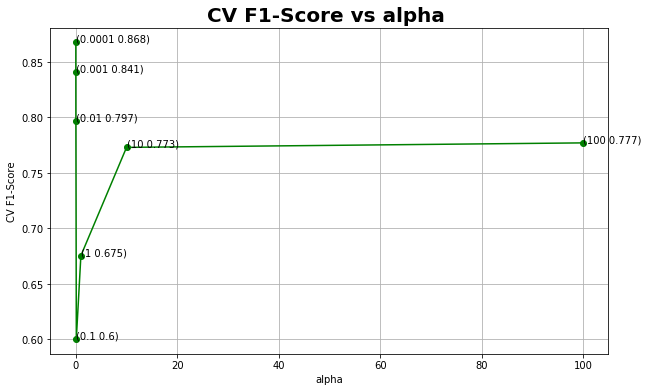

In [20]:
%%time
grid_estimator = SGD_Train(X_train_bowuni, y_train)

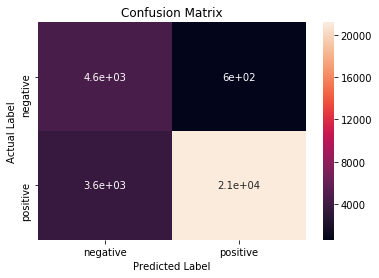

[[ 4604   596]
 [ 3594 21206]]

Test Error : 0.14
Test Accuracy : 86.033 %
True Negative : 4604
False Positive : 596
False Negative : 3594
True Positive : 21206
Precission Score : 0.901
Recall Score : 0.86
F1 Score : 0.871





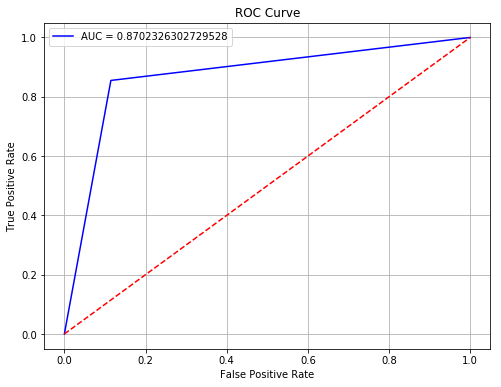

Classification Report for Model is :
             precision    recall  f1-score   support

          0       0.56      0.89      0.69      5200
          1       0.97      0.86      0.91     24800

avg / total       0.90      0.86      0.87     30000

Wall time: 533 ms


In [21]:
%%time
SGD_Test(X_test_bowuni, y_test)

### [7.2] Bag Of Words(bigram) : <a name="bowbi"></a>

In [22]:
%%time
bow_bigram = CountVectorizer(ngram_range=(1, 2),min_df = 0.0005)
X_train_bowbi = bow_bigram.fit_transform(X_train)
X_test_bowbi = bow_bigram.transform(X_test)
print("The shape of Train Data: ", X_train_bowbi.get_shape())
print("The shape of Test Data: ", X_test_bowbi.get_shape())

The shape of Train Data:  (70000, 10983)
The shape of Test Data:  (30000, 10983)
Wall time: 12.3 s


In [23]:
from sklearn.preprocessing import normalize
X_train_bowbi = normalize(X_train_bowbi)
X_test_bowbi = normalize(X_test_bowbi)


Grid Scores for Model is:
 [mean: 0.88217, std: 0.00562, params: {'alpha': 0.0001}, mean: 0.84771, std: 0.00894, params: {'alpha': 0.001}, mean: 0.79424, std: 0.02003, params: {'alpha': 0.01}, mean: 0.46729, std: 0.30052, params: {'alpha': 0.1}, mean: 0.49667, std: 0.37289, params: {'alpha': 1}, mean: 0.70247, std: 0.22346, params: {'alpha': 10}, mean: 0.77710, std: 0.02979, params: {'alpha': 100}]

Best Parameters(alpha):  {'alpha': 0.0001}

Best F1-Score: 0.882 
Wall time: 7.8 s


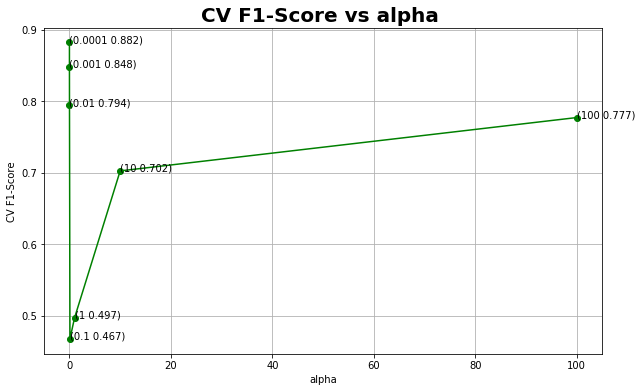

In [24]:
%%time
grid_estimator = SGD_Train(X_train_bowbi, y_train)

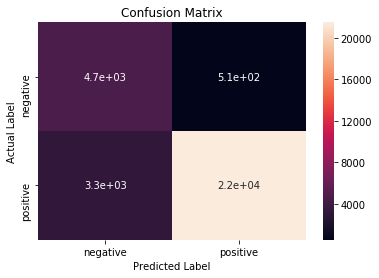

[[ 4689   511]
 [ 3285 21515]]

Test Error : 0.127
Test Accuracy : 87.347 %
True Negative : 4689
False Positive : 511
False Negative : 3285
True Positive : 21515
Precission Score : 0.909
Recall Score : 0.873
F1 Score : 0.883





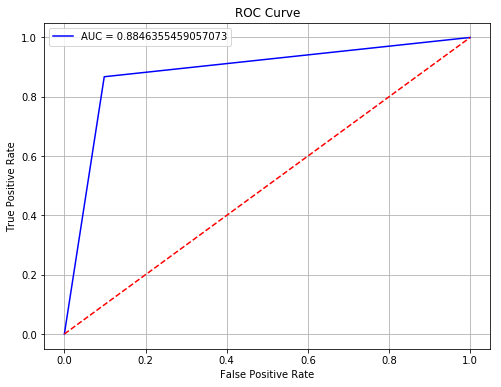

Classification Report for Model is :
             precision    recall  f1-score   support

          0       0.59      0.90      0.71      5200
          1       0.98      0.87      0.92     24800

avg / total       0.91      0.87      0.88     30000

Wall time: 387 ms


In [25]:
%%time
SGD_Test(X_test_bowbi, y_test)

### [7.3] TF-IDF(unigram) : <a name="tfidfuni"></a>

In [26]:
%%time
tfidf_unigram = TfidfVectorizer(min_df = 0.0005)
X_train_tfidfuni = tfidf_unigram.fit_transform(X_train)
X_test_tfidfuni = tfidf_unigram.transform(X_test)
print("The shape of Train Data: ", X_train_tfidfuni.get_shape())
print("The shape of Test Data: ", X_test_tfidfuni.get_shape())

The shape of Train Data:  (70000, 3904)
The shape of Test Data:  (30000, 3904)
Wall time: 3.91 s


In [27]:
from sklearn.preprocessing import normalize
X_train_tfidfuni = normalize(X_train_tfidfuni)
X_test_tfidfuni = normalize(X_test_tfidfuni)


Grid Scores for Model is:
 [mean: 0.87462, std: 0.00521, params: {'alpha': 0.0001}, mean: 0.85950, std: 0.00714, params: {'alpha': 0.001}, mean: 0.81331, std: 0.08511, params: {'alpha': 0.01}, mean: 0.73323, std: 0.18359, params: {'alpha': 0.1}, mean: 0.71321, std: 0.22564, params: {'alpha': 1}, mean: 0.63639, std: 0.29507, params: {'alpha': 10}, mean: 0.77710, std: 0.02979, params: {'alpha': 100}]

Best Parameters(alpha):  {'alpha': 0.0001}

Best F1-Score: 0.875 
Wall time: 5.77 s


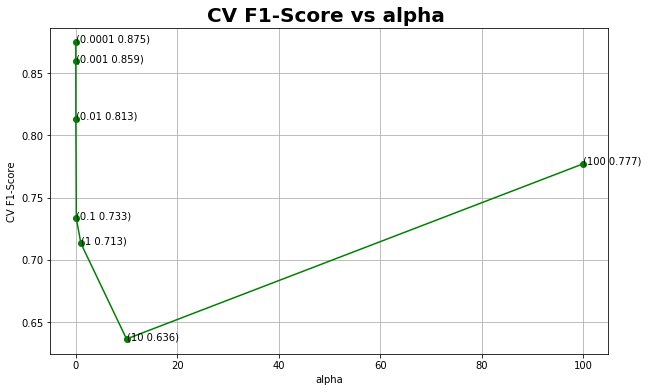

In [28]:
%%time
grid_estimator = SGD_Train(X_train_tfidfuni, y_train)

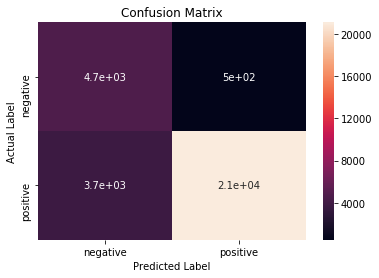

[[ 4696   504]
 [ 3727 21073]]

Test Error : 0.141
Test Accuracy : 85.897 %
True Negative : 4696
False Positive : 504
False Negative : 3727
True Positive : 21073
Precission Score : 0.904
Recall Score : 0.859
F1 Score : 0.871





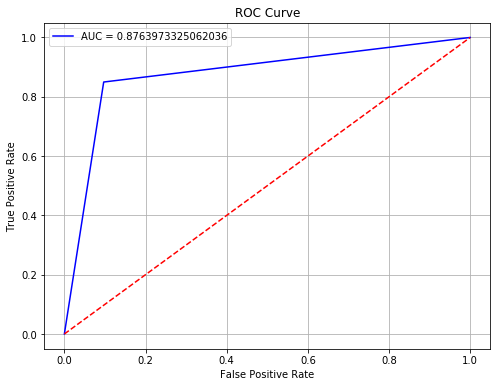

Classification Report for Model is :
             precision    recall  f1-score   support

          0       0.56      0.90      0.69      5200
          1       0.98      0.85      0.91     24800

avg / total       0.90      0.86      0.87     30000

Wall time: 512 ms


In [29]:
%%time
SGD_Test(X_test_tfidfuni, y_test)

### [7.4] TF-IDF(bigram) : <a name="tfidfbi"></a>

In [30]:
%%time
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2),min_df = 0.0005)
X_train_tfidfbi = tfidf_bigram.fit_transform(X_train)
X_test_tfidfbi = tfidf_bigram.transform(X_test)
print("The shape of Train Data: ", X_train_tfidfbi.get_shape())
print("The shape of Test Data: ", X_test_tfidfbi.get_shape())

The shape of Train Data:  (70000, 10983)
The shape of Test Data:  (30000, 10983)
Wall time: 12.9 s


In [31]:
from sklearn.preprocessing import normalize
X_train_tfidfbi = normalize(X_train_tfidfbi)
X_test_tfidfbi = normalize(X_test_tfidfbi)


Grid Scores for Model is:
 [mean: 0.89425, std: 0.00419, params: {'alpha': 0.0001}, mean: 0.87292, std: 0.00721, params: {'alpha': 0.001}, mean: 0.66891, std: 0.27330, params: {'alpha': 0.01}, mean: 0.36069, std: 0.29215, params: {'alpha': 0.1}, mean: 0.47258, std: 0.35646, params: {'alpha': 1}, mean: 0.77710, std: 0.02979, params: {'alpha': 10}, mean: 0.70025, std: 0.22441, params: {'alpha': 100}]

Best Parameters(alpha):  {'alpha': 0.0001}

Best F1-Score: 0.894 
Wall time: 7.26 s


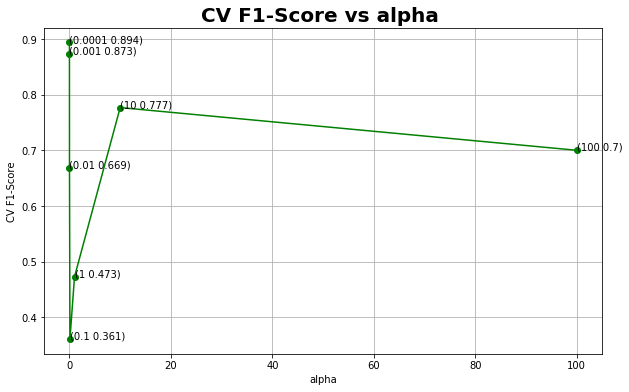

In [32]:
%%time
grid_estimator = SGD_Train(X_train_tfidfbi, y_train)

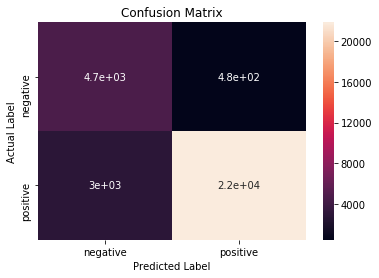

[[ 4722   478]
 [ 2954 21846]]

Test Error : 0.114
Test Accuracy : 88.56 %
True Negative : 4722
False Positive : 478
False Negative : 2954
True Positive : 21846
Precission Score : 0.916
Recall Score : 0.886
F1 Score : 0.894





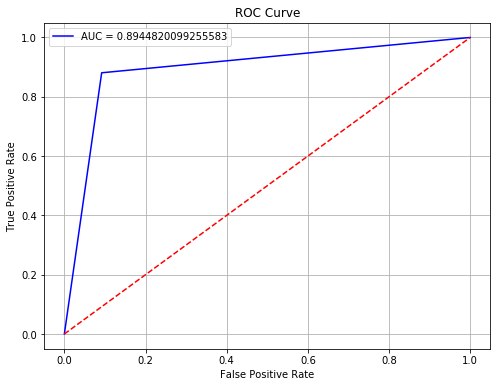

Classification Report for Model is :
             precision    recall  f1-score   support

          0       0.62      0.91      0.73      5200
          1       0.98      0.88      0.93     24800

avg / total       0.92      0.89      0.89     30000

Wall time: 380 ms


In [33]:
%%time
SGD_Test(X_test_tfidfbi, y_test)

## [7.5] Average Word2Vec : <a name="avgw2v"></a>

In [34]:
i=0
list_of_sent_train=[]
for sent in X_train:
    list_of_sent_train.append(sent.split())

In [35]:
print(X_train[5])
print("****************************************************************************")
print(list_of_sent_train[5])

sick scad nasti toothpick counter tint concept one long overdu except welcom color vibrant not offens tast blend opinion smooth wilton past youll need experi bit get hue right first well worth
****************************************************************************
['sick', 'scad', 'nasti', 'toothpick', 'counter', 'tint', 'concept', 'one', 'long', 'overdu', 'except', 'welcom', 'color', 'vibrant', 'not', 'offens', 'tast', 'blend', 'opinion', 'smooth', 'wilton', 'past', 'youll', 'need', 'experi', 'bit', 'get', 'hue', 'right', 'first', 'well', 'worth']


In [36]:
i=0
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())

In [37]:
print(X_test[5])
print("****************************************************************************")
print(list_of_sent_test[5])

glad found larger bag best coffe ever longer reorder follow direct not add sugar sweetner cream milk coffe put starbuck shame
****************************************************************************
['glad', 'found', 'larger', 'bag', 'best', 'coffe', 'ever', 'longer', 'reorder', 'follow', 'direct', 'not', 'add', 'sugar', 'sweetner', 'cream', 'milk', 'coffe', 'put', 'starbuck', 'shame']


In [38]:
%%time
## Word2Vec Model considering only those words that occur atleast 5 times in the corpus
min_count = 5
w2v_model = Word2Vec(list_of_sent_train, min_count = min_count, size = 200, workers = 4)

Wall time: 10.4 s


In [39]:
w2v_words = list(w2v_model.wv.vocab)

In [40]:
%%time
X_train_avgw2v = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train):
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [01:27<00:00, 796.83it/s]


Wall time: 1min 27s


In [41]:
%%time
X_test_avgw2v = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:39<00:00, 754.12it/s]


Wall time: 39.8 s


In [42]:
from sklearn.preprocessing import normalize
X_train_avgw2v = normalize(X_train_avgw2v)
X_test_avgw2v = normalize(X_test_avgw2v)

In [43]:
print("Number of rows in Train Data: ",len(X_train_avgw2v))
print("Number of features in Train Data: ",len(X_train_avgw2v[0]))
print("Number of rows in Test Data: ",len(X_test_avgw2v))
print("Number of features in Test Data: ",len(X_test_avgw2v[0]))

Number of rows in Train Data:  70000
Number of features in Train Data:  200
Number of rows in Test Data:  30000
Number of features in Test Data:  200



Grid Scores for Model is:
 [mean: 0.83027, std: 0.05694, params: {'alpha': 0.0001}, mean: 0.82923, std: 0.01490, params: {'alpha': 0.001}, mean: 0.82645, std: 0.02103, params: {'alpha': 0.01}, mean: 0.81602, std: 0.04748, params: {'alpha': 0.1}, mean: 0.26498, std: 0.34056, params: {'alpha': 1}, mean: 0.69623, std: 0.22549, params: {'alpha': 10}, mean: 0.70025, std: 0.22441, params: {'alpha': 100}]

Best Parameters(alpha):  {'alpha': 0.0001}

Best F1-Score: 0.83 
Wall time: 15.7 s


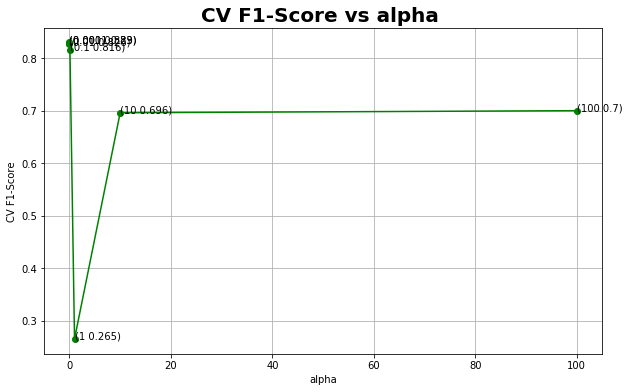

In [48]:
%%time
grid_estimator = SGD_Train(X_train_avgw2v, y_train)

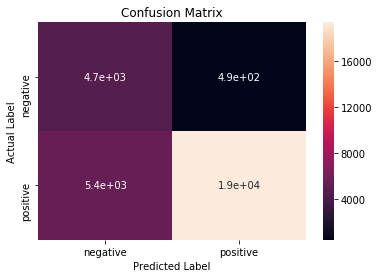

[[ 4714   486]
 [ 5433 19367]]

Test Error : 0.197
Test Accuracy : 80.27 %
True Negative : 4714
False Positive : 486
False Negative : 5433
True Positive : 19367
Precission Score : 0.887
Recall Score : 0.803
F1 Score : 0.824





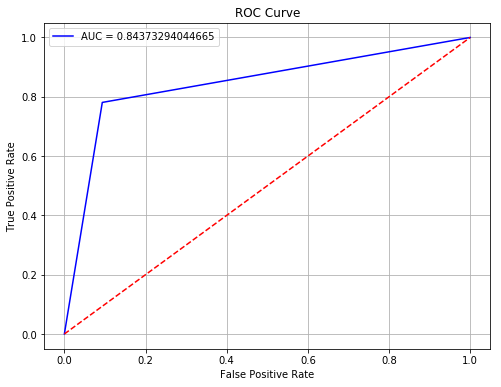

Classification Report for Model is :
             precision    recall  f1-score   support

          0       0.46      0.91      0.61      5200
          1       0.98      0.78      0.87     24800

avg / total       0.89      0.80      0.82     30000

Wall time: 403 ms


In [49]:
%%time
SGD_Test(X_test_avgw2v, y_test)

## [7.6] TF-IDF Weighted Word2Vec : <a name="tfidfw2v"></a>

In [50]:
%%time
tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectors = tfidf.fit_transform(X_train)

Wall time: 12.6 s


In [51]:
dictionary = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))
print(len(dictionary))

975434


In [52]:
%%time
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train):
    sent_vec = np.zeros(200)
    weight_sum =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [01:49<00:00, 637.64it/s]


Wall time: 1min 51s


In [53]:
%%time
X_test_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(200)
    weight_sum =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidfw2v.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:45<00:00, 656.42it/s]


Wall time: 45.7 s


In [54]:
from sklearn.preprocessing import normalize
X_train_tfidfw2v = normalize(X_train_tfidfw2v)
X_test_tfidfw2v = normalize(X_test_tfidfw2v)

In [55]:
print("Number of rows in Train Data: ",len(X_train_tfidfw2v))
print("Number of features in Train Data: ",len(X_train_tfidfw2v[0]))
print("Number of rows in Test Data: ",len(X_test_tfidfw2v))
print("Number of features in Test Data: ",len(X_test_tfidfw2v[0]))

Number of rows in Train Data:  70000
Number of features in Train Data:  200
Number of rows in Test Data:  30000
Number of features in Test Data:  200



Grid Scores for Model is:
 [mean: 0.81437, std: 0.03965, params: {'alpha': 0.0001}, mean: 0.82763, std: 0.01770, params: {'alpha': 0.001}, mean: 0.81870, std: 0.02357, params: {'alpha': 0.01}, mean: 0.58543, std: 0.25956, params: {'alpha': 0.1}, mean: 0.56246, std: 0.33899, params: {'alpha': 1}, mean: 0.62574, std: 0.29569, params: {'alpha': 10}, mean: 0.63133, std: 0.29584, params: {'alpha': 100}]

Best Parameters(alpha):  {'alpha': 0.001}

Best F1-Score: 0.828 
Wall time: 16.4 s


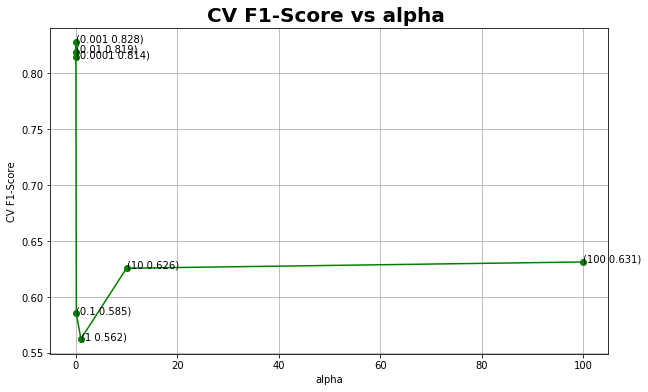

In [56]:
%%time
grid_estimator = SGD_Train(X_train_tfidfw2v, y_train)

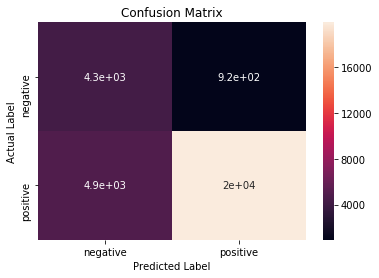

[[ 4278   922]
 [ 4895 19905]]

Test Error : 0.194
Test Accuracy : 80.61 %
True Negative : 4278
False Positive : 922
False Negative : 4895
True Positive : 19905
Precission Score : 0.871
Recall Score : 0.806
F1 Score : 0.824





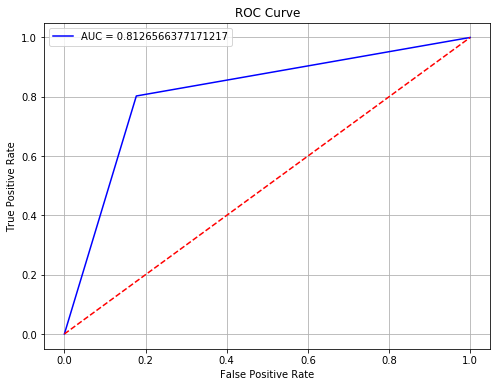

Classification Report for Model is :
             precision    recall  f1-score   support

          0       0.47      0.82      0.60      5200
          1       0.96      0.80      0.87     24800

avg / total       0.87      0.81      0.82     30000

Wall time: 510 ms


In [57]:
%%time
SGD_Test(X_test_tfidfw2v, y_test)

### OBSERVATIONS :
-  It is observed that using <b>SGD with hinge loss</b>, <b>TFIDF(bigram) performs best</b> with a F1-score of 0.894.
-  Now we would apply SVC with rbf kernel on TFIDF(bigram) to find the best hyperparameters and test accuracy.

### Applying SVC RBF to TFIDF(bigram) :

<b> GRID SEARCH : </b>

In [61]:
%%time
grid_estimator = SVC_GridTrain(X_train_tfidfbi,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 355.8min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 1599.0min finished



Grid Scores for Model is:
 [mean: 0.47952, std: 0.35801, params: {'C': 0.01, 'gamma': 0.01}, mean: 0.48861, std: 0.36516, params: {'C': 0.01, 'gamma': 0.1}, mean: 0.68826, std: 0.32499, params: {'C': 0.01, 'gamma': 1}, mean: 0.32272, std: 0.34925, params: {'C': 0.01, 'gamma': 10}, mean: 0.32272, std: 0.34925, params: {'C': 0.01, 'gamma': 100}, mean: 0.57659, std: 0.31481, params: {'C': 0.1, 'gamma': 0.01}, mean: 0.87081, std: 0.01290, params: {'C': 0.1, 'gamma': 0.1}, mean: 0.88583, std: 0.00767, params: {'C': 0.1, 'gamma': 1}, mean: 0.77201, std: 0.02314, params: {'C': 0.1, 'gamma': 10}, mean: 0.77201, std: 0.02314, params: {'C': 0.1, 'gamma': 100}, mean: 0.87023, std: 0.00982, params: {'C': 1, 'gamma': 0.01}, mean: 0.89446, std: 0.00446, params: {'C': 1, 'gamma': 0.1}, mean: 0.91931, std: 0.00827, params: {'C': 1, 'gamma': 1}, mean: 0.77209, std: 0.02304, params: {'C': 1, 'gamma': 10}, mean: 0.77205, std: 0.02309, params: {'C': 1, 'gamma': 100}, mean: 0.89445, std: 0.00429, params: 

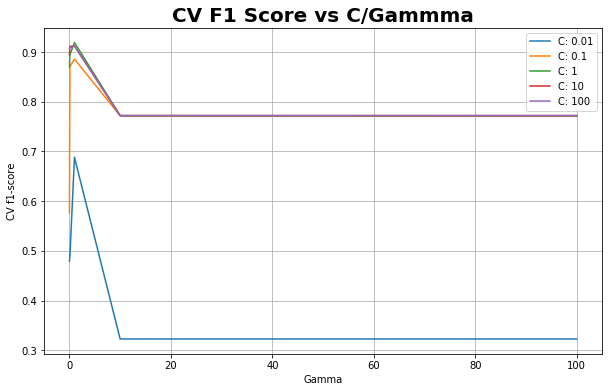

In [67]:
scores = [x[1] for x in grid_estimator.grid_scores_]
scores = np.array(scores).reshape(len(param_svc['C']), len(param_svc['gamma']))


plt.figure(figsize = (10,6))
for indices, i in enumerate(param_svc['C']):
    plt.plot(param_svc['gamma'], scores[indices], label='C: '+str(i))
plt.legend()
plt.title("CV F1 Score vs C/Gammma",fontsize = 20,fontweight = "bold")
plt.xlabel('Gamma')
plt.ylabel('CV f1-score')
plt.grid("on")
plt.show()

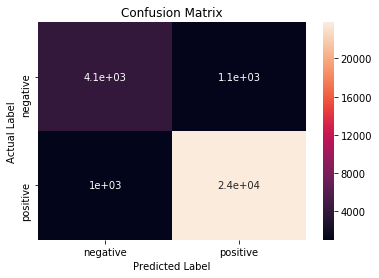

[[ 4084  1116]
 [ 1018 23782]]

Test Error : 0.071
Test Accuracy : 92.887 %
True Negative : 4084
False Positive : 1116
False Negative : 1018
True Positive : 23782
Precission Score : 0.928
Recall Score : 0.929
F1 Score : 0.929





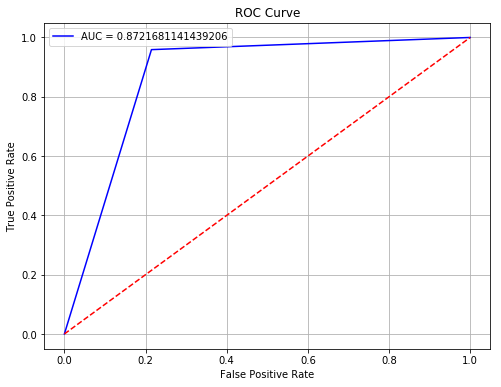

Classification Report for Model is :
             precision    recall  f1-score   support

          0       0.80      0.79      0.79      5200
          1       0.96      0.96      0.96     24800

avg / total       0.93      0.93      0.93     30000

Wall time: 6min 27s


In [68]:
%%time
SVC_Test(X_test_tfidfbi,y_test,grid_estimator)

<b> RANDOM SEARCH : </b>

In [60]:
%%time
random_estimator = SVC_RandomTrain(X_train_tfidfbi,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 190.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 251.8min finished



Grid Scores for Model is:
 [mean: 0.90540, std: 0.00409, params: {'C': 0.97125675067799, 'gamma': 0.247186642142312}, mean: 0.90739, std: 0.00383, params: {'C': 6.901134338291023, 'gamma': 0.06990994922956224}, mean: 0.91439, std: 0.00145, params: {'C': 5.879654622281287, 'gamma': 0.16844985341940383}, mean: 0.91658, std: 0.00473, params: {'C': 14.548846577463515, 'gamma': 0.37141031016441667}, mean: 0.90208, std: 0.00425, params: {'C': 25.706984105407695, 'gamma': 0.011783374206350223}, mean: 0.89128, std: 0.00489, params: {'C': 7.658054190275369, 'gamma': 0.009509045023538724}, mean: 0.90930, std: 0.00284, params: {'C': 9.064189319722589, 'gamma': 0.07973937981339807}, mean: 0.88980, std: 0.00490, params: {'C': 6.582058129220457, 'gamma': 0.00952677011067996}, mean: 0.89815, std: 0.00413, params: {'C': 6.743648858029447, 'gamma': 0.022216634397163575}, mean: 0.88530, std: 0.00528, params: {'C': 3.2317739724994103, 'gamma': 0.013733242889701725}]

Best HyperParameters:  {'C': 14.5488

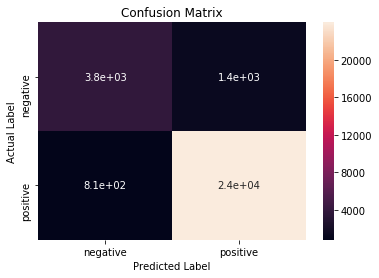

[[ 3823  1377]
 [  810 23990]]

Test Error : 0.073
Test Accuracy : 92.71 %
True Negative : 3823
False Positive : 1377
False Negative : 810
True Positive : 23990
Precission Score : 0.925
Recall Score : 0.927
F1 Score : 0.925





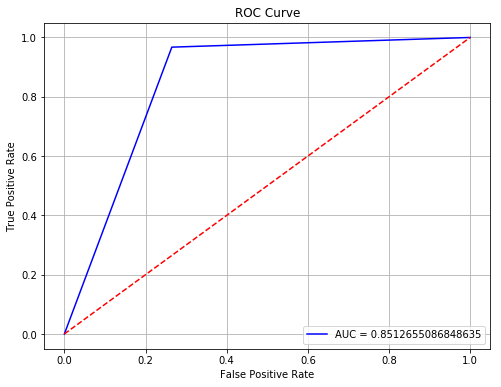

Classification Report for Model is :
             precision    recall  f1-score   support

          0       0.83      0.74      0.78      5200
          1       0.95      0.97      0.96     24800

avg / total       0.92      0.93      0.93     30000

Wall time: 4min 27s


In [64]:
%%time
SVC_Test(X_test_tfidfbi,y_test,random_estimator)

## [8] Conclusion : <a name="conclusion"></a>

<b>Using SGD(hinge loss)</b> : 

| Featurization Model | <b>Accuracy</b> | <b>Precission</b> | <b>Recall</b> | <b>F1 score</b> |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| <b>BOW(unigram)</b> | 86.033 % | 0.901  | 0.86 | 0.871 |
| <b>BOW(bigram)</b> | 87.347 % | 0.909  | 0.873 | 0.883 |
| <b>TF-IDF(unigram)</b> | 85.897 % | 0.904  | 0.859 | 0.871 |
| <b>TF-IDF(bigram)</b> | 88.56 % | 0.916  | 0.886 | 0.894 |
| <b>Average Word2Vec</b> | 80.27 % | 0.887  | 0.803 | 0.824 |
| <b>TF-IDF Weighted Word2Vec</b> | 80.61 % | 0.871  | 0.806 | 0.824 |

<br>
<b>1 - </b><b>Using SGD with hinge loss,TFIDf(bigram)</b> gives best performance with F1 score of <b>0.894</b>.

<b>2 - </b>Hence, SVC with "rbf" kernalization is applied to TFIDf(bigram) and following results are obtained -

| | <b>Accuracy</b> | <b>Precission</b> | <b>Recall</b> | <b>F1 score</b> |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| <b>Grid Search CV</b> | 92.887 % | 0.928  | 0.929 | 0.929 |
| <b>Random Search CV</b> | 92.71 % | 0.925  | 0.927 | 0925 |

<b>3 - </b>It is observed that there is a <b>significant improvement</b> in F1-score from 0.892 to <b>0.929</b> when used with kernalization trick.

<b>4 - </b>Both Random Search and Grid Search provided same results, with Random Serach taking very less time as compared to Grid Search.

<b>5 - </b>It would be better to use Random Search for cross validation with models having more than 1 hyperparameters and high Train time complexity.

<b>6 - </b><b>Run Time complexity of SVC rbf is very high</b>, it is not desirable to use it for internet applications(low latency).